In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### download data

In [2]:
#! wget -q http://files.grouplens.org/datasets/movielens/ml-1m.zip
#! unzip ml-1m.zip

### define description and load data

In [3]:
age_desc = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
occupation_desc = { 0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                4: "college/grad student", 5: "customer service", 6: "doctor/health care",
                7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
                12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
                17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer" }

In [4]:
rating_data = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    engine="python",
    encoding="latin-1",
    names=['userid', 'movieid', 'rating', 'timestamp'])

user_data = pd.read_csv(
    "ml-1m/users.dat", 
    sep='::', 
    engine='python', 
    encoding='latin-1',
    names=['userid', 'gender', 'age', 'occupation', 'zipcode']
)
user_data['age_desc'] = user_data['age'].apply(lambda x: age_desc[x])
user_data['occ_desc'] = user_data['occupation'].apply(lambda x: occupation_desc[x])

movie_data = pd.read_csv(
    "ml-1m/movies.dat",
    sep='::', 
    engine='python', 
    encoding='latin-1',
    names=['movieid', 'title', 'genre']
)

dataset = pd.merge(pd.merge(rating_data, movie_data, how="left", on="movieid"), user_data, how="left", on="userid")

### change indices of user and movie

In [5]:
## there are gap in movie column, len(dataset['movieid'].unique())=3706, dataset['movieid'].max()=3952
## there are no gap in user column, len(dataset['userid'].unique())=6040, dataset['userid'].max()=6040

def check_adj_col(dataset, col_list):
    adj_list = []
    adj_dataset=dataset[col_list]
    for i in adj_dataset.columns:
        if len(dataset[i].unique()) != dataset[i].max():
            adj_list.append(i)
    return adj_list          

In [6]:
check_adj_col(dataset, ['userid', 'movieid'])

['movieid']

In [7]:
adj_col = dataset['movieid']
adj_col_uni=adj_col.sort_values().unique()
adj_df = pd.DataFrame(adj_col_uni).reset_index().rename(columns = {0:'movieid','index':'adj_movieid'})

In [8]:
dataset = pd.merge(adj_df,dataset,how="right", on="movieid") 

In [9]:
dataset['adj_userid'] = dataset['userid'] - 1

### train validation split

In [10]:
dataset = dataset.sample(frac=1, replace=False)

In [11]:
n_split = int(len(dataset)*.7)
trainset = dataset[:n_split]
validset = dataset[n_split:]

### build the model

In [12]:
def create_embeddings(num_users, num_movies, dim):
    user_embeddings = tf.get_variable(
        "theta",
        shape = [num_users, dim],
        dtype = tf.float32,
        initializer = tf.truncated_normal_initializer(mean=0, stddev=.05)
    )
    movie_embeddings = tf.get_variable(
        "phi",
        shape = [num_movies, dim],
        dtype = tf.float32,
        initializer = tf.truncated_normal_initializer(mean=0, stddev=.05)
    )
    return user_embeddings, movie_embeddings

def create_dataset(user_ids, movie_ids, ratings):
    user_id_var = tf.get_variable("userid", initializer=user_ids, trainable=False)
    movie_id_var = tf.get_variable("movieid", initializer=movie_ids, trainable=False)
    ratings_var = tf.get_variable("ratings", initializer=np.asarray(ratings, dtype=np.float32), trainable=False)
    return user_id_var, movie_id_var, ratings_var

def lookup_embeddings(user_embeddings, movie_embeddings, user_ids, movie_ids): 
    selected_user_embeddings = tf.gather(user_embeddings, user_ids)
    selected_movie_embeddings = tf.gather(movie_embeddings, movie_ids)
    return selected_user_embeddings, selected_movie_embeddings

def predict(selected_user_embeddings, selected_movie_embeddings):
    selected_predictions = tf.reduce_sum(
        selected_user_embeddings * selected_movie_embeddings,
        axis = 1
    ) 
    return selected_predictions 

def colaborative_filtering(user_embeddings, movie_embeddings, user_ids, movie_ids):
    sel_usr_embs, sel_mov_embs = lookup_embeddings(user_embeddings, movie_embeddings, user_ids, movie_ids)
    predictions = predict(sel_usr_embs, sel_mov_embs)
    return predictions, sel_usr_embs, sel_mov_embs

def mean_squared_difference(predictions, ratings):
    difference = tf.reduce_mean(tf.squared_difference(predictions, ratings))
    return difference

def cal_reg_loss(predictions, ratings, lam, selected_user_embeddings, selected_movie_embeddings):
    loss = mean_squared_difference(predictions, ratings)\
        + lam*tf.reduce_mean(tf.pow(selected_user_embeddings,2)) \
        + lam*tf.reduce_mean(tf.pow(selected_movie_embeddings,2))
    return loss

### set hyper parameters

In [13]:
emb_dim = 8
learning_rate = 50
epochs = 1000
lam = 0.02

### train model

In [20]:
with tf.Graph().as_default():
    with tf.variable_scope("embeddings"):
        usr_embs, mov_embs = create_embeddings(dataset.adj_userid.max()+1, dataset.adj_movieid.max()+1, emb_dim)
    with tf.variable_scope("train_set"):
        train_data = trainset[["adj_userid", "adj_movieid", "rating"]].values.T
        train_usr_ids, train_mov_ids, train_ratings = create_dataset(*train_data)
    with tf.variable_scope("valid_set"):
        valid_data = validset[["adj_userid", "adj_movieid", "rating"]].values.T
        valid_usr_ids, valid_mov_ids, valid_ratings = create_dataset(*valid_data)
    with tf.variable_scope("training"):
        train_preds, usr_embs_reg, mov_embs_reg = colaborative_filtering(usr_embs, mov_embs, train_usr_ids, train_mov_ids)
        train_loss = cal_reg_loss(train_preds, train_ratings, lam, usr_embs_reg, mov_embs_reg)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        train_usr_embs = optimizer.minimize(train_loss, var_list=[usr_embs])
        train_mov_embs = optimizer.minimize(train_loss, var_list=[mov_embs]) 
        real_train_loss = mean_squared_difference(train_preds,train_ratings)
    with tf.variable_scope("validation"):
        valid_preds, usr_embs_val, mov_embs_val = colaborative_filtering(usr_embs, mov_embs, valid_usr_ids, valid_mov_ids)
        valid_loss = cal_reg_loss(valid_preds, valid_ratings, lam, usr_embs_val, usr_embs_val)
        real_valid_loss = mean_squared_difference(valid_preds,valid_ratings)
    with tf.Session() as sess:
        writer = tf.summary.FileWriter('Graph',sess.graph)
        sess.run(tf.global_variables_initializer())
        train_loss_history = []
        real_train_loss_history =[]
        real_valid_loss_history = []
        for i in range(epochs):
            current_train_loss, _ = sess.run([train_loss, train_usr_embs])
            print("regularized train loss after %ith user emb. opt. step: %f"%(i+1, current_train_loss))
            current_train_loss, _ = sess.run([train_loss, train_mov_embs])
            print("regularized train loss after %ith movie emb. opt. step: %f"%(i+1, current_train_loss))
            current_real_train_loss = sess.run(real_train_loss)
            current_real_valid_loss = sess.run(real_valid_loss)
            print("real valid loss after %ith movie emb. opt. step: %f"%(i+1, current_real_valid_loss))
            train_loss_history.append(current_train_loss)
            real_train_loss_history.append(current_real_train_loss)
            real_valid_loss_history.append(current_real_valid_loss)
        final_user_embeddings, final_movie_embeddings = sess.run([usr_embs, mov_embs])
        final_valid_predictions = sess.run(valid_preds) 
        writer.close()

regularized train loss after 1th user emb. opt. step: 14.071951
regularized train loss after 1th movie emb. opt. step: 14.071903
real valid loss after 1th movie emb. opt. step: 14.083876
regularized train loss after 2th user emb. opt. step: 14.071842
regularized train loss after 2th movie emb. opt. step: 14.071799
real valid loss after 2th movie emb. opt. step: 14.083880
regularized train loss after 3th user emb. opt. step: 14.071755
regularized train loss after 3th movie emb. opt. step: 14.071702
real valid loss after 3th movie emb. opt. step: 14.083869
regularized train loss after 4th user emb. opt. step: 14.071662
regularized train loss after 4th movie emb. opt. step: 14.071610
real valid loss after 4th movie emb. opt. step: 14.083849
regularized train loss after 5th user emb. opt. step: 14.071560
regularized train loss after 5th movie emb. opt. step: 14.071511
real valid loss after 5th movie emb. opt. step: 14.083836
regularized train loss after 6th user emb. opt. step: 14.071439
r

real valid loss after 44th movie emb. opt. step: 3.995893
regularized train loss after 45th user emb. opt. step: 3.953145
regularized train loss after 45th movie emb. opt. step: 3.811812
real valid loss after 45th movie emb. opt. step: 3.724772
regularized train loss after 46th user emb. opt. step: 3.682864
regularized train loss after 46th movie emb. opt. step: 3.558520
real valid loss after 46th movie emb. opt. step: 3.485873
regularized train loss after 47th user emb. opt. step: 3.444959
regularized train loss after 47th movie emb. opt. step: 3.335118
real valid loss after 47th movie emb. opt. step: 3.274544
regularized train loss after 48th user emb. opt. step: 3.234658
regularized train loss after 48th movie emb. opt. step: 3.137286
real valid loss after 48th movie emb. opt. step: 3.086918
regularized train loss after 49th user emb. opt. step: 3.048120
regularized train loss after 49th movie emb. opt. step: 2.961483
real valid loss after 49th movie emb. opt. step: 2.919740
regular

regularized train loss after 89th user emb. opt. step: 1.152540
regularized train loss after 89th movie emb. opt. step: 1.147788
real valid loss after 89th movie emb. opt. step: 1.158926
regularized train loss after 90th user emb. opt. step: 1.142526
regularized train loss after 90th movie emb. opt. step: 1.138003
real valid loss after 90th movie emb. opt. step: 1.149137
regularized train loss after 91th user emb. opt. step: 1.132943
regularized train loss after 91th movie emb. opt. step: 1.128637
real valid loss after 91th movie emb. opt. step: 1.139776
regularized train loss after 92th user emb. opt. step: 1.123783
regularized train loss after 92th movie emb. opt. step: 1.119673
real valid loss after 92th movie emb. opt. step: 1.130816
regularized train loss after 93th user emb. opt. step: 1.115016
regularized train loss after 93th movie emb. opt. step: 1.111102
real valid loss after 93th movie emb. opt. step: 1.122226
regularized train loss after 94th user emb. opt. step: 1.106624
r

regularized train loss after 132th movie emb. opt. step: 0.939166
real valid loss after 132th movie emb. opt. step: 0.949238
regularized train loss after 133th user emb. opt. step: 0.937808
regularized train loss after 133th movie emb. opt. step: 0.936988
real valid loss after 133th movie emb. opt. step: 0.947039
regularized train loss after 134th user emb. opt. step: 0.935660
regularized train loss after 134th movie emb. opt. step: 0.934871
real valid loss after 134th movie emb. opt. step: 0.944897
regularized train loss after 135th user emb. opt. step: 0.933571
regularized train loss after 135th movie emb. opt. step: 0.932804
real valid loss after 135th movie emb. opt. step: 0.942810
regularized train loss after 136th user emb. opt. step: 0.931537
regularized train loss after 136th movie emb. opt. step: 0.930788
real valid loss after 136th movie emb. opt. step: 0.940780
regularized train loss after 137th user emb. opt. step: 0.929557
regularized train loss after 137th movie emb. opt.

real valid loss after 175th movie emb. opt. step: 0.889419
regularized train loss after 176th user emb. opt. step: 0.879031
regularized train loss after 176th movie emb. opt. step: 0.878754
real valid loss after 176th movie emb. opt. step: 0.888558
regularized train loss after 177th user emb. opt. step: 0.878170
regularized train loss after 177th movie emb. opt. step: 0.877904
real valid loss after 177th movie emb. opt. step: 0.887715
regularized train loss after 178th user emb. opt. step: 0.877327
regularized train loss after 178th movie emb. opt. step: 0.877064
real valid loss after 178th movie emb. opt. step: 0.886887
regularized train loss after 179th user emb. opt. step: 0.876497
regularized train loss after 179th movie emb. opt. step: 0.876238
real valid loss after 179th movie emb. opt. step: 0.886067
regularized train loss after 180th user emb. opt. step: 0.875679
regularized train loss after 180th movie emb. opt. step: 0.875422
real valid loss after 180th movie emb. opt. step: 

regularized train loss after 219th movie emb. opt. step: 0.850160
real valid loss after 219th movie emb. opt. step: 0.860982
regularized train loss after 220th user emb. opt. step: 0.849794
regularized train loss after 220th movie emb. opt. step: 0.849621
real valid loss after 220th movie emb. opt. step: 0.860483
regularized train loss after 221th user emb. opt. step: 0.849257
regularized train loss after 221th movie emb. opt. step: 0.849086
real valid loss after 221th movie emb. opt. step: 0.859989
regularized train loss after 222th user emb. opt. step: 0.848726
regularized train loss after 222th movie emb. opt. step: 0.848552
real valid loss after 222th movie emb. opt. step: 0.859498
regularized train loss after 223th user emb. opt. step: 0.848195
regularized train loss after 223th movie emb. opt. step: 0.848020
real valid loss after 223th movie emb. opt. step: 0.859008
regularized train loss after 224th user emb. opt. step: 0.847667
regularized train loss after 224th movie emb. opt.

real valid loss after 262th movie emb. opt. step: 0.842081
regularized train loss after 263th user emb. opt. step: 0.828673
regularized train loss after 263th movie emb. opt. step: 0.828498
real valid loss after 263th movie emb. opt. step: 0.841684
regularized train loss after 264th user emb. opt. step: 0.828212
regularized train loss after 264th movie emb. opt. step: 0.828038
real valid loss after 264th movie emb. opt. step: 0.841294
regularized train loss after 265th user emb. opt. step: 0.827754
regularized train loss after 265th movie emb. opt. step: 0.827577
real valid loss after 265th movie emb. opt. step: 0.840903
regularized train loss after 266th user emb. opt. step: 0.827292
regularized train loss after 266th movie emb. opt. step: 0.827119
real valid loss after 266th movie emb. opt. step: 0.840515
regularized train loss after 267th user emb. opt. step: 0.826833
regularized train loss after 267th movie emb. opt. step: 0.826658
real valid loss after 267th movie emb. opt. step: 

regularized train loss after 306th user emb. opt. step: 0.809384
regularized train loss after 306th movie emb. opt. step: 0.809198
real valid loss after 306th movie emb. opt. step: 0.825970
regularized train loss after 307th user emb. opt. step: 0.808945
regularized train loss after 307th movie emb. opt. step: 0.808762
real valid loss after 307th movie emb. opt. step: 0.825630
regularized train loss after 308th user emb. opt. step: 0.808510
regularized train loss after 308th movie emb. opt. step: 0.808324
real valid loss after 308th movie emb. opt. step: 0.825291
regularized train loss after 309th user emb. opt. step: 0.808073
regularized train loss after 309th movie emb. opt. step: 0.807887
real valid loss after 309th movie emb. opt. step: 0.824951
regularized train loss after 310th user emb. opt. step: 0.807634
regularized train loss after 310th movie emb. opt. step: 0.807448
real valid loss after 310th movie emb. opt. step: 0.824613
regularized train loss after 311th user emb. opt. 

regularized train loss after 349th movie emb. opt. step: 0.790727
real valid loss after 349th movie emb. opt. step: 0.812191
regularized train loss after 350th user emb. opt. step: 0.790496
regularized train loss after 350th movie emb. opt. step: 0.790307
real valid loss after 350th movie emb. opt. step: 0.811889
regularized train loss after 351th user emb. opt. step: 0.790073
regularized train loss after 351th movie emb. opt. step: 0.789886
real valid loss after 351th movie emb. opt. step: 0.811590
regularized train loss after 352th user emb. opt. step: 0.789652
regularized train loss after 352th movie emb. opt. step: 0.789461
real valid loss after 352th movie emb. opt. step: 0.811291
regularized train loss after 353th user emb. opt. step: 0.789233
regularized train loss after 353th movie emb. opt. step: 0.789046
real valid loss after 353th movie emb. opt. step: 0.810992
regularized train loss after 354th user emb. opt. step: 0.788814
regularized train loss after 354th movie emb. opt.

regularized train loss after 393th user emb. opt. step: 0.772782
regularized train loss after 393th movie emb. opt. step: 0.772592
real valid loss after 393th movie emb. opt. step: 0.799734
regularized train loss after 394th user emb. opt. step: 0.772381
regularized train loss after 394th movie emb. opt. step: 0.772196
real valid loss after 394th movie emb. opt. step: 0.799473
regularized train loss after 395th user emb. opt. step: 0.771980
regularized train loss after 395th movie emb. opt. step: 0.771793
real valid loss after 395th movie emb. opt. step: 0.799210
regularized train loss after 396th user emb. opt. step: 0.771581
regularized train loss after 396th movie emb. opt. step: 0.771391
real valid loss after 396th movie emb. opt. step: 0.798948
regularized train loss after 397th user emb. opt. step: 0.771183
regularized train loss after 397th movie emb. opt. step: 0.770991
real valid loss after 397th movie emb. opt. step: 0.798687
regularized train loss after 398th user emb. opt. 

regularized train loss after 436th movie emb. opt. step: 0.756048
real valid loss after 436th movie emb. opt. step: 0.789336
regularized train loss after 437th user emb. opt. step: 0.755860
regularized train loss after 437th movie emb. opt. step: 0.755683
real valid loss after 437th movie emb. opt. step: 0.789115
regularized train loss after 438th user emb. opt. step: 0.755496
regularized train loss after 438th movie emb. opt. step: 0.755316
real valid loss after 438th movie emb. opt. step: 0.788900
regularized train loss after 439th user emb. opt. step: 0.755131
regularized train loss after 439th movie emb. opt. step: 0.754952
real valid loss after 439th movie emb. opt. step: 0.788682
regularized train loss after 440th user emb. opt. step: 0.754768
regularized train loss after 440th movie emb. opt. step: 0.754589
real valid loss after 440th movie emb. opt. step: 0.788468
regularized train loss after 441th user emb. opt. step: 0.754405
regularized train loss after 441th movie emb. opt.

real valid loss after 479th movie emb. opt. step: 0.780926
regularized train loss after 480th user emb. opt. step: 0.741047
regularized train loss after 480th movie emb. opt. step: 0.740885
real valid loss after 480th movie emb. opt. step: 0.780752
regularized train loss after 481th user emb. opt. step: 0.740726
regularized train loss after 481th movie emb. opt. step: 0.740563
real valid loss after 481th movie emb. opt. step: 0.780581
regularized train loss after 482th user emb. opt. step: 0.740402
regularized train loss after 482th movie emb. opt. step: 0.740241
real valid loss after 482th movie emb. opt. step: 0.780412
regularized train loss after 483th user emb. opt. step: 0.740082
regularized train loss after 483th movie emb. opt. step: 0.739923
real valid loss after 483th movie emb. opt. step: 0.780242
regularized train loss after 484th user emb. opt. step: 0.739761
regularized train loss after 484th movie emb. opt. step: 0.739604
real valid loss after 484th movie emb. opt. step: 

regularized train loss after 523th movie emb. opt. step: 0.727910
real valid loss after 523th movie emb. opt. step: 0.774238
regularized train loss after 524th user emb. opt. step: 0.727773
regularized train loss after 524th movie emb. opt. step: 0.727629
real valid loss after 524th movie emb. opt. step: 0.774103
regularized train loss after 525th user emb. opt. step: 0.727493
regularized train loss after 525th movie emb. opt. step: 0.727349
real valid loss after 525th movie emb. opt. step: 0.773971
regularized train loss after 526th user emb. opt. step: 0.727218
regularized train loss after 526th movie emb. opt. step: 0.727071
real valid loss after 526th movie emb. opt. step: 0.773841
regularized train loss after 527th user emb. opt. step: 0.726936
regularized train loss after 527th movie emb. opt. step: 0.726795
real valid loss after 527th movie emb. opt. step: 0.773711
regularized train loss after 528th user emb. opt. step: 0.726658
regularized train loss after 528th movie emb. opt.

regularized train loss after 567th user emb. opt. step: 0.716503
regularized train loss after 567th movie emb. opt. step: 0.716374
real valid loss after 567th movie emb. opt. step: 0.769122
regularized train loss after 568th user emb. opt. step: 0.716257
regularized train loss after 568th movie emb. opt. step: 0.716131
real valid loss after 568th movie emb. opt. step: 0.769020
regularized train loss after 569th user emb. opt. step: 0.716012
regularized train loss after 569th movie emb. opt. step: 0.715887
real valid loss after 569th movie emb. opt. step: 0.768921
regularized train loss after 570th user emb. opt. step: 0.715768
regularized train loss after 570th movie emb. opt. step: 0.715641
real valid loss after 570th movie emb. opt. step: 0.768822
regularized train loss after 571th user emb. opt. step: 0.715528
regularized train loss after 571th movie emb. opt. step: 0.715400
real valid loss after 571th movie emb. opt. step: 0.768723
regularized train loss after 572th user emb. opt. 

regularized train loss after 610th movie emb. opt. step: 0.706570
real valid loss after 610th movie emb. opt. step: 0.765300
regularized train loss after 611th user emb. opt. step: 0.706468
regularized train loss after 611th movie emb. opt. step: 0.706357
real valid loss after 611th movie emb. opt. step: 0.765226
regularized train loss after 612th user emb. opt. step: 0.706257
regularized train loss after 612th movie emb. opt. step: 0.706143
real valid loss after 612th movie emb. opt. step: 0.765147
regularized train loss after 613th user emb. opt. step: 0.706046
regularized train loss after 613th movie emb. opt. step: 0.705932
real valid loss after 613th movie emb. opt. step: 0.765071
regularized train loss after 614th user emb. opt. step: 0.705832
regularized train loss after 614th movie emb. opt. step: 0.705723
real valid loss after 614th movie emb. opt. step: 0.764999
regularized train loss after 615th user emb. opt. step: 0.705625
regularized train loss after 615th movie emb. opt.

real valid loss after 653th movie emb. opt. step: 0.762383
regularized train loss after 654th user emb. opt. step: 0.697955
regularized train loss after 654th movie emb. opt. step: 0.697856
real valid loss after 654th movie emb. opt. step: 0.762324
regularized train loss after 655th user emb. opt. step: 0.697769
regularized train loss after 655th movie emb. opt. step: 0.697671
real valid loss after 655th movie emb. opt. step: 0.762265
regularized train loss after 656th user emb. opt. step: 0.697585
regularized train loss after 656th movie emb. opt. step: 0.697489
real valid loss after 656th movie emb. opt. step: 0.762208
regularized train loss after 657th user emb. opt. step: 0.697402
regularized train loss after 657th movie emb. opt. step: 0.697305
real valid loss after 657th movie emb. opt. step: 0.762151
regularized train loss after 658th user emb. opt. step: 0.697217
regularized train loss after 658th movie emb. opt. step: 0.697122
real valid loss after 658th movie emb. opt. step: 

regularized train loss after 697th user emb. opt. step: 0.690543
regularized train loss after 697th movie emb. opt. step: 0.690457
real valid loss after 697th movie emb. opt. step: 0.760111
regularized train loss after 698th user emb. opt. step: 0.690383
regularized train loss after 698th movie emb. opt. step: 0.690299
real valid loss after 698th movie emb. opt. step: 0.760065
regularized train loss after 699th user emb. opt. step: 0.690225
regularized train loss after 699th movie emb. opt. step: 0.690141
real valid loss after 699th movie emb. opt. step: 0.760018
regularized train loss after 700th user emb. opt. step: 0.690066
regularized train loss after 700th movie emb. opt. step: 0.689979
real valid loss after 700th movie emb. opt. step: 0.759975
regularized train loss after 701th user emb. opt. step: 0.689905
regularized train loss after 701th movie emb. opt. step: 0.689820
real valid loss after 701th movie emb. opt. step: 0.759933
regularized train loss after 702th user emb. opt. 

real valid loss after 740th movie emb. opt. step: 0.758418
regularized train loss after 741th user emb. opt. step: 0.683931
regularized train loss after 741th movie emb. opt. step: 0.683854
real valid loss after 741th movie emb. opt. step: 0.758381
regularized train loss after 742th user emb. opt. step: 0.683791
regularized train loss after 742th movie emb. opt. step: 0.683715
real valid loss after 742th movie emb. opt. step: 0.758349
regularized train loss after 743th user emb. opt. step: 0.683650
regularized train loss after 743th movie emb. opt. step: 0.683577
real valid loss after 743th movie emb. opt. step: 0.758311
regularized train loss after 744th user emb. opt. step: 0.683513
regularized train loss after 744th movie emb. opt. step: 0.683439
real valid loss after 744th movie emb. opt. step: 0.758279
regularized train loss after 745th user emb. opt. step: 0.683372
regularized train loss after 745th movie emb. opt. step: 0.683299
real valid loss after 745th movie emb. opt. step: 

regularized train loss after 784th movie emb. opt. step: 0.678209
real valid loss after 784th movie emb. opt. step: 0.757092
regularized train loss after 785th user emb. opt. step: 0.678152
regularized train loss after 785th movie emb. opt. step: 0.678084
real valid loss after 785th movie emb. opt. step: 0.757063
regularized train loss after 786th user emb. opt. step: 0.678029
regularized train loss after 786th movie emb. opt. step: 0.677963
real valid loss after 786th movie emb. opt. step: 0.757037
regularized train loss after 787th user emb. opt. step: 0.677907
regularized train loss after 787th movie emb. opt. step: 0.677841
real valid loss after 787th movie emb. opt. step: 0.757011
regularized train loss after 788th user emb. opt. step: 0.677785
regularized train loss after 788th movie emb. opt. step: 0.677719
real valid loss after 788th movie emb. opt. step: 0.756989
regularized train loss after 789th user emb. opt. step: 0.677663
regularized train loss after 789th movie emb. opt.

regularized train loss after 828th user emb. opt. step: 0.673175
regularized train loss after 828th movie emb. opt. step: 0.673116
real valid loss after 828th movie emb. opt. step: 0.756081
regularized train loss after 829th user emb. opt. step: 0.673066
regularized train loss after 829th movie emb. opt. step: 0.673008
real valid loss after 829th movie emb. opt. step: 0.756063
regularized train loss after 830th user emb. opt. step: 0.672957
regularized train loss after 830th movie emb. opt. step: 0.672899
real valid loss after 830th movie emb. opt. step: 0.756042
regularized train loss after 831th user emb. opt. step: 0.672849
regularized train loss after 831th movie emb. opt. step: 0.672791
real valid loss after 831th movie emb. opt. step: 0.756023
regularized train loss after 832th user emb. opt. step: 0.672742
regularized train loss after 832th movie emb. opt. step: 0.672683
real valid loss after 832th movie emb. opt. step: 0.756005
regularized train loss after 833th user emb. opt. 

real valid loss after 871th movie emb. opt. step: 0.755342
regularized train loss after 872th user emb. opt. step: 0.668649
regularized train loss after 872th movie emb. opt. step: 0.668597
real valid loss after 872th movie emb. opt. step: 0.755326
regularized train loss after 873th user emb. opt. step: 0.668552
regularized train loss after 873th movie emb. opt. step: 0.668502
real valid loss after 873th movie emb. opt. step: 0.755313
regularized train loss after 874th user emb. opt. step: 0.668458
regularized train loss after 874th movie emb. opt. step: 0.668404
real valid loss after 874th movie emb. opt. step: 0.755300
regularized train loss after 875th user emb. opt. step: 0.668361
regularized train loss after 875th movie emb. opt. step: 0.668311
real valid loss after 875th movie emb. opt. step: 0.755284
regularized train loss after 876th user emb. opt. step: 0.668266
regularized train loss after 876th movie emb. opt. step: 0.668216
real valid loss after 876th movie emb. opt. step: 

regularized train loss after 915th user emb. opt. step: 0.664716
regularized train loss after 915th movie emb. opt. step: 0.664669
real valid loss after 915th movie emb. opt. step: 0.754783
regularized train loss after 916th user emb. opt. step: 0.664629
regularized train loss after 916th movie emb. opt. step: 0.664584
real valid loss after 916th movie emb. opt. step: 0.754772
regularized train loss after 917th user emb. opt. step: 0.664544
regularized train loss after 917th movie emb. opt. step: 0.664498
real valid loss after 917th movie emb. opt. step: 0.754762
regularized train loss after 918th user emb. opt. step: 0.664460
regularized train loss after 918th movie emb. opt. step: 0.664413
real valid loss after 918th movie emb. opt. step: 0.754750
regularized train loss after 919th user emb. opt. step: 0.664373
regularized train loss after 919th movie emb. opt. step: 0.664327
real valid loss after 919th movie emb. opt. step: 0.754740
regularized train loss after 920th user emb. opt. 

real valid loss after 958th movie emb. opt. step: 0.754396
regularized train loss after 959th user emb. opt. step: 0.661111
regularized train loss after 959th movie emb. opt. step: 0.661067
real valid loss after 959th movie emb. opt. step: 0.754389
regularized train loss after 960th user emb. opt. step: 0.661032
regularized train loss after 960th movie emb. opt. step: 0.660991
real valid loss after 960th movie emb. opt. step: 0.754382
regularized train loss after 961th user emb. opt. step: 0.660954
regularized train loss after 961th movie emb. opt. step: 0.660915
real valid loss after 961th movie emb. opt. step: 0.754374
regularized train loss after 962th user emb. opt. step: 0.660877
regularized train loss after 962th movie emb. opt. step: 0.660837
real valid loss after 962th movie emb. opt. step: 0.754367
regularized train loss after 963th user emb. opt. step: 0.660803
regularized train loss after 963th movie emb. opt. step: 0.660761
real valid loss after 963th movie emb. opt. step: 

### plot losses

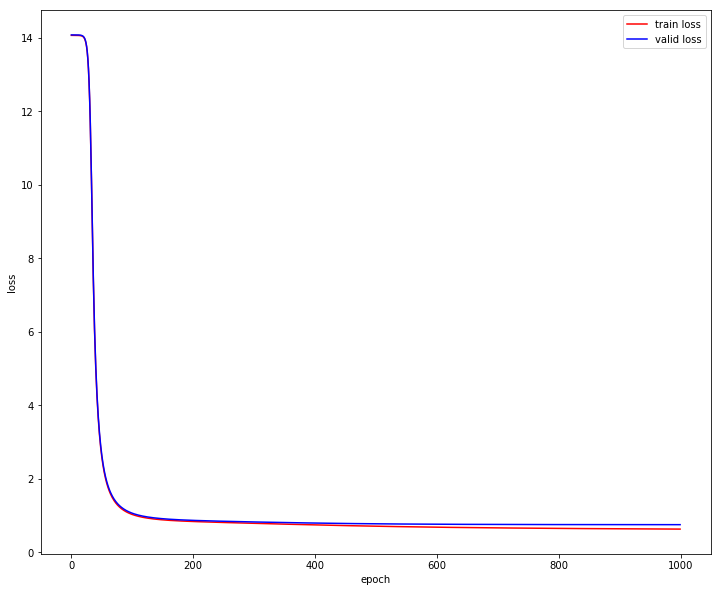

In [21]:
plt.figure(figsize=(12,10))
plt.plot(real_train_loss_history, color="red", label="train loss")
plt.plot(real_valid_loss_history, color="blue", label="valid loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

### results on validation set

In [22]:
results = validset[["gender", "age_desc","occ_desc", "title", "genre", "rating"]].copy()
results["prediction (rnd.)"] = np.asarray(np.round(final_valid_predictions), dtype=np.int16)
results["prediction (prc.)"] = final_valid_predictions
results

,gender,age_desc,occ_desc,title,genre,rating,prediction (rnd.),prediction (prc.)
40438,M,18-24,technician/engineer,"Birdcage, The (1996)",Comedy,3,4,4.173681
31473,M,18-24,other or not specified,Beautiful Girls (1996),Drama,4,4,3.754229
959242,M,35-44,retired,Mad Max 2 (a.k.a. The Road Warrior) (1981),Action|Sci-Fi,4,3,3.376611
896083,M,50-55,writer,Thelma & Louise (1991),Action|Drama,3,4,3.577984
589400,M,35-44,programmer,"Dark Crystal, The (1982)",Children's|Fantasy|Sci-Fi,3,4,3.839198
639276,M,25-34,other or not specified,King Kong (1933),Action|Adventure|Horror,5,4,4.497379
882187,M,45-49,technician/engineer,Mission to Mars (2000),Sci-Fi,3,2,2.448461
433879,M,56+,scientist,"Fifth Element, The (1997)",Action|Sci-Fi,3,3,2.739178
257676,M,35-44,self-employed,Bitter Sugar (Azucar Amargo) (1996),Drama,3,3,3.028550
811935,M,25-34,executive/managerial,Falling Down (1993),Action|Drama,3,4,3.829830
